In [1]:
import os, json
from Tint_Matlab import *
import struct
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
def samples_to_array(A, channels=[]):
    """This will take data matrix A, and convert it into a numpy array, there are three samples of
    64 channels in this matrix, however their channels do need to be re-mapped"""
    
    
    if channels == []:
        channels = np.arange(64)+1
    else:
        channels = np.asarray(channels)
    
    A = np.asarray(A)
    
    sample_num = int(len(A)/64) # get the sample numbers
    
    sample_array = np.zeros((len(channels),sample_num)) # creating a 64x3 array of zeros (64 channels, 3 samples)
    
    '''
    for i in range(3):
        # there are three samples
        
        current_sample = A[:64] # defines current samples
        
        for k in range(64):
            
            sample_array[k,i] = current_sample[get_remap_chan(k+1)]
        
        A = A[64:]  # discards the used samples
    '''
    
    for i, channel in enumerate(channels):
        sample_array[i,:] = A[get_sample_indices(channel, sample_num)]
            
    return sample_array

def get_sample_indices(channel_number, samples):
    remap_channel = get_remap_chan(channel_number)
    
    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)
    
    #return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)

def get_remap_chan(chan_num):
    """There is re-mapping, thus to get the correct channel data, you need to incorporate re-mapping
    input will be a channel from 1 to 64, and will return the remapped channel"""
    
    remap_channels = np.array([32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 
                      6, 7, 40, 41, 42, 43, 44, 45, 46, 47, 8, 9, 10, 11, 
                      12, 13, 14, 15, 48, 49, 50, 51, 52, 53, 54, 55, 16, 17, 
                      18, 19, 20, 21, 22, 23, 56, 57, 58, 59, 60, 61, 62, 63, 
                      24, 25, 26, 27, 28, 29, 30, 31])
    
    return remap_channels[chan_num-1]

def readBin(bin_filename):
    
    bin_directory = os.path.dirname(bin_filename)
    
    session = os.path.basename(os.path.splitext(bin_filename)[0])
    
    set_filename = os.path.join(bin_directory, '%s.set' % session)
    
    if not os.path.exists(set_filename):
        return "No Set File!"
    
    with open(bin_filename, 'rb') as f:
        for line in f:
            pass
            
            
def find_sub(string, sub):
    '''finds all instances of a substring within a string and outputs a list of indices'''
    result = []
    k = 0
    while k < len(string):
        k = string.find(sub, k)
        if k == -1:
            return result
        else:
            result.append(k)
            k += 1  # change to k += len(sub) to not search overlapping results
    return result


def get_active_tetrode(set_filename):
    """in the .set files it will say collectMask_X Y for each tetrode number to tell you if 
    it is active or not. T1 = ch1-ch4, T2 = ch5-ch8, etc."""
    active_tetrode = []
    
    with open(set_filename) as f:
        for line in f:
            
            #line = line.decode(encoding='UTF-8')
            active_tetrode_str = 'collectMask_'
            # collectMask_X Y, where x is the tetrode number, and Y is eitehr on or off (1 or 0)
            if active_tetrode_str in line:
                tetrode_str, tetrode_status = line.split(' ')
                if int(tetrode_status) == 1:
                    # then the tetrode is saved
                    tetrode_str.find('_')
                    tet_number = int(tetrode_str[tetrode_str.find('_')+1:])
                    active_tetrode.append(tet_number)
                    
    return active_tetrode

In [3]:
#bin_filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\20170823-3-CYLINDEROPENFIELD_Mult.bin'
bin_filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\20170823-2-CYLINDEROPENFIELD.bin'
bin_directory = os.path.dirname(bin_filename)
session = os.path.basename(os.path.splitext(bin_filename)[0])
set_filename = os.path.join(bin_directory, '%s.set' % session)

# Determining How Many Samples Are Recorded

In [4]:
#Fs = 48000
#duration = iteration_count * 3 / Fs
#print(duration)

In [5]:
#Determining How Many Samples Are Recorded
byte_count = os.path.getsize(bin_filename)
bytes_per_iteration = 432
iteration_count = int(byte_count/bytes_per_iteration)  
sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)
Fs = 48000
duration = iteration_count * 3 / Fs
print(byte_count, iteration_count)

4147243200 9600100


# Reading Position Data

In [6]:
def get_bin_pos(bin_filename):
    pos_sample_num = 0
    
    byte_count = os.path.getsize(bin_filename)
    bytes_per_iteration = 432
    iteration_count = int(byte_count/bytes_per_iteration)  
    sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)
    
    DaqFs = 48000
    duration = iteration_count * 3 / DaqFs
    duration = np.ceil(duration)
    
    #Reading the Data
    
    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16
    
    byte_skip = data_byte_len +  trailer_byte_len # 384 ephys data bytes + 16 trailer bytes
    
    pos_Fs = 50
    n_samples = int(duration*pos_Fs)
    
    post = []
    posx = []
    posy = []
    
    #post = np.zeros((n_samples,1))
    #posx = np.zeros_like(post)
    #posy = np.zeros_like(post)
    
    with open(bin_filename, 'rb') as f:
        #open the bin file
        #f.seek(12)
        
        for i in range(iteration_count):
            byte_id = f.read(4)

            if 'ADU2' in str(byte_id):
                f.seek(8, 1)  # moves the current position by 10 bytes
                position_data = f.read(20)
                
                time_data = position_data[:4]
                time_data = np.asarray(struct.unpack('i', time_data))
                
                position_data = np.asarray(struct.unpack('8h', position_data[4:]))
                
                f.seek(byte_skip, 1)
                
                post.append(time_data)
                posx.append(position_data[0])
                posy.append(position_data[1])
                    
                #post[pos_sample_num] = time_data
                #posx[pos_sample_num] = position_data[0]
                #posy[pos_sample_num] = position_data[1]
                
                pos_sample_num += 1
                
            else:
                f.seek(bytes_per_iteration-4, 1)
    
    post = np.asarray(post).astype(float)
    posx = np.asarray(posx).astype(float)
    posy = np.asarray(posy).astype(float)
    
    # converting the time value from a frame count to a time value
    timebase = 50
    post = np.multiply(post, (1 / int(timebase)))  # converting the frame number from Axona to the time value

    # find the 1023 values, which indicates the light wasn't tracked

    invalid_positions = np.where((posx == 1023) | (posy == 1023))[0]
    
    posx[invalid_positions] = np.nan
    posy[invalid_positions] = np.nan        
    
    #print(pos_sample_num)
    
    return posx.reshape((len(posx),1)), posy.reshape((len(posy),1)), post.reshape((len(post),1))

[[ 7974.16    10.     136.  ]
 [ 8328.86    15.      70.  ]
 [ 8328.88    15.      69.  ]
 ..., 
 [ 8928.86   144.      27.  ]
 [ 8928.86   144.      27.  ]
 [ 8928.88   145.      28.  ]]


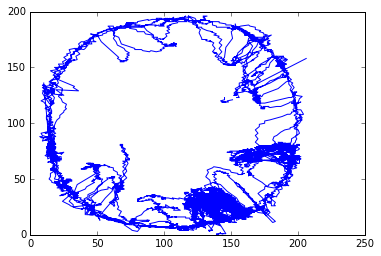

In [11]:
posx, posy, post = get_bin_pos(bin_filename)
#%timeit posx, posy, post = get_bin_pos(bin_filename)
print(np.hstack((post, posx, posy)))

plt.plot(posx, posy)

In [12]:
with open(bin_filename, 'rb') as f:
    #open the bin file
    #f.seek(12)

    for i in range(iteration_count):
        header = f.read(32)
        data = f.read(384)
        trailer = f.read(16)
        
        print('header', header)
        print('data', data) 
        print('trailer', trailer)
        
        #print('ADU' in str(byte_id))
        break
        
byte_id = struct.unpack('4c', header[:4])
print(byte_id)

header b'ADU1\xd1\xb1\xde\x06\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
data b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xaa\x1fB\x1b\x9a<\xa6\xe4\xf8\xfe\x82\xfeX\xfen\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc8\x1f>\x1b\x96<r\xe4\x0e\xff.\xfe\xdc\xfd\xfe\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

# Reading the Data



In [7]:
def get_lfp_bytes(iterations):
    """This function works, but the strategy I use didn't. I was going to slice the bytearray like you would
    a numpy array but that didn't work"""
    data_byte_len = 384
    indices = np.arange(data_byte_len)
    indices = np.tile(indices, (1, iterations))
    indices = indices.flatten()

    offset_indices = np.arange(iterations)
    offset_indices = offset_indices*432 + 32
    offset_indices = np.tile(offset_indices,(384,1))
    offset_indices = offset_indices.flatten(order='F')
    
    return indices + offset_indices
    
def get_lfp_indices(iteration):
    data_byte_len = 192
    indices = np.arange(data_byte_len)
    indices = np.tile(indices, (1, iterations))
    indices = indices.flatten()

    offset_indices = np.arange(iterations)
    offset_indices = offset_indices*213 + 13
    offset_indices = np.tile(offset_indices,(192,1))
    offset_indices = offset_indices.flatten(order='F')
    
    return indices + offset_indices

    
def find_n(iterations, optimal=1000):
    n = optimal
    
    while True:
        if iterations % n == 0:

            return n
        else:
            n -= 1
    return 'abort'

    
def get_channel_bytes(channel_number, samples):
    """This will get the indices of the data if it is just the lfp data (not the bytes header bytes or trailing bytes)"""
    remap_channel = get_remap_chan(channel_number)
    
    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)
    
    #return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)


def get_channel_from_tetrode(tetrode):
    """This function will take the tetrode number and return the Axona channel numbers
    i.e. Tetrode 1 = Ch1 -Ch4, Tetrode 2 = Ch5-Ch8, etc"""
    tetrode = int(tetrode) # just in case the user gave a string as the tetrode
    
    return np.arange(1,5) + 4*(tetrode-1)

def get_bin_data(bin_filename, tetrode):
    """This function will be used to acquire the actual lfp data given the .bin filename,
    and the tetrode that you want to get"""
    #Reading the Data
    
    channels = get_channel_from_tetrode(tetrode)
    
    byte_count = os.path.getsize(bin_filename)
    
    bytes_per_iteration = 432
    
    iteration_count = int(byte_count/bytes_per_iteration)  
    total_sample_count = iteration_count * 192  # each iteration has 192 samples (64*3), sample acount including all channels
    channel_sample_count = iteration_count * 3
    #DaqFs = 48000
    #duration = iteration_count * 3 / DaqFs
    #duration = np.ceil(duration)
    
    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16

    # read the set file to get the active channel information
    active_tetrodes = get_active_tetrode(set_filename)
    
    try:
        all_data = np.zeros(total_sample_count)
        tetrode_data = np.zeros((4, channel_sample_count))
        LargeData = False
        all_data = None
        tetrode_data = None
    except MemoryError:
        # Cannot read all the data into memory, do it one iteration at a time
        LargeData = True
        all_data = None
        tetrode_data = np.zeros((4, channel_sample_count))
    
    
    with open(bin_filename, 'rb') as f:
        #open the bin file
        f.seek(header_byte_len) # moves the current position to the LFP data
        data = np.zeros(total_sample_count)
        
        total_data_bytes = int(64*3*iteration_count)
        print(iteration_count)
        
        if not LargeData:
                
            # the data can be read all at once
            
            # attempting to read all data into memory
            
            data = f.readlines()
            for i in range(iteration_count):
                
                '''
                if i % 100000 == 0:
                    print(i)
                '''  
                data_sample = f.read(data_byte_len)
                data_sample = np.asarray(struct.unpack('192h', data_sample))
                data[i*192:(i+1)*192] = data_sample
                
                f.seek(bytes_per_iteration, 1) # moving current position to next data portion
                
            #data = np.asarray(struct.unpack('%dh' % total_data_bytes, data)) # unpacks all the data
            
            tetrode_data = samples_to_array(data, channels=channels.tolist())
            
        else:
            # the data is too large to load at once, so just do it one iteration at a time
            print('Performing slower method due to memory error failing to allow loading all the data at once.')
            # attempting to read all data into memory
            for i in range(iteration_count):
                
                _ = f.read(header_byte_len)

                data_sample = f.read(data_byte_len)
                data_sample = np.asarray(struct.unpack('192h', data_sample))
                
                tetrode_data[:,np.arange(i,i+4)] = samples_to_array(data_sample, channels=channels.tolist())
                
                f.seek(bytes_per_iteration, 1) # moving current position to next data portion
            
    return tetrode_data
    

In [14]:
with open(bin_filename, 'rb') as f:
    #open the bin file
    #f.seek(12)
    bytes_per_iteration = 432
    byte_skip = 400 # 384 ephys data bytes + 16 trailer bytes
    
    for i in range(iteration_count):
        byte_id = f.read(4).decode(encoding='UTF-8')
        
        if 'ADU2' in byte_id:
            f.seek(8, 1)  # moves the current position by 10 bytes
            position_data = f.read(20)
            frame_count = position_data[:4]
            print(position_data[4:])
            position_data = np.asarray(struct.unpack('8h', position_data[4:]))
            print(position_data)
            f.seek(byte_skip,1)
            break
            
        else:
            f.seek(bytes_per_iteration-4, 1)
        

b'\n\x00\x88\x00\xff\x03\xff\x03\x00\x00|\x00\x00\x00|\x00'
[  10  136 1023 1023    0  124    0  124]


In [8]:
def get_bin_data2(bin_filename, tetrode):
    """This function will be used to acquire the actual lfp data given the .bin filename,
    and the tetrode that you want to get"""
    #Reading the Data
    
    # byte_id (4 bytes), packetnumber (4 bytes) = 2i
    # dig in (2), sync in (2) = 2h
    # frame_cnt (4) = i
    # 8 words (2/each), 192 ephys data points (2 each), dig out (2), stim stat(2), 10 bytes of zeros (5x 2 bytes), 2 bytes ascii
    # string = 2i,2h,211i
    iteration_string = '%di%dhi%dh' % (2, 2, 8+192+1+1+5+1) 
    
    channels = get_channel_from_tetrode(tetrode)
    
    byte_count = os.path.getsize(bin_filename)
    
    bytes_per_iteration = 432
    
    iteration_count = int(byte_count/bytes_per_iteration)  
    total_sample_count = iteration_count * 192  # each iteration has 192 samples (64*3), sample acount including all channels
    channel_sample_count = iteration_count * 3
    #DaqFs = 48000
    #duration = iteration_count * 3 / DaqFs
    #duration = np.ceil(duration)
    
    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16

    # read the set file to get the active channel information
    active_tetrodes = get_active_tetrode(set_filename)
    
    try:
        all_data = np.zeros(2*total_sample_count)
        tetrode_data = np.zeros((4, channel_sample_count))
        LargeData = False
        all_data = None
        tetrode_data = None
        
        simul_iterations = iteration_count # number of simultaneous iterations

        n = 1
        byte_chunksize = simul_iterations*bytes_per_iteration
        
    except MemoryError:
        # Cannot read all the data into memory, do it one iteration at a time
        LargeData = True
        all_data = None
        tetrode_data = None
        print("performing a slower method")
        n = find_n(iteration_count, optimal=1000) # finds how many loops to do
        print('Number of loops: %d' % int(n))
        simul_iterations = int(iteration_count / n)
        simul_samples = simul_iterations*3
        byte_chunksize = simul_iterations*bytes_per_iteration
    
    with open(bin_filename, 'rb') as f:
        #open the bin file
        #f.seek(header_byte_len) # moves the current position to the LFP data
        # data = np.zeros(total_sample_count)
        tetrode_data = np.zeros((4, channel_sample_count))
        
        total_data_bytes = int(64*3*iteration_count)
        
        for i in range(n):
            data = f.read(byte_chunksize)
            
            data = np.asarray(struct.unpack(simul_iterations*iteration_string, data))
            data = data[get_lfp_indices(simul_iterations)]
            
            data = samples_to_array(data, channels=channels.tolist())
            
            tetrode_data[simul_samples*i:simul_samples(i+1)] = samples_to_array(data, channels=channels.tolist())
    
        
    return tetrode_data

In [ ]:
data = get_bin_data2(bin_filename, 1)
print('done')

In [155]:
# byte_id (4 bytes), packetnumber (4 bytes) = 2i
# dig in (2), sync in (2) = 2h
# frame_cnt (4) = i
# 8 words (2/each), 192 ephys data points (2 each), dig out (2), stim stat(2), 10 bytes of zeros (5x 2 bytes), 2 bytes ascii
# string = 2i,2h,211i
iteration_string = '%di%dhi%dh' % (2, 2, 8+192+1+1+5+1) 

num_iterations = 10
a = data[:num_iterations*432]

b = np.asarray(struct.unpack(num_iterations*iteration_string, a))
#print(b)
lfp = b[get_lfp_indices(num_iterations)]
print(lfp)

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0   8106   6978  15514  -7002   -264   -382   -424
    878      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0   8136   6974  15510
  -7054   -242   -466   -548    766      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

In [67]:
# find valid channels
valid_channels = []
try:
    # if the channel is not being recorded on, it will have all zero values
    channel_list = np.arange(64)+1
    channel_data = samples_to_array(data, channels=channel_list.tolist())
    valid_channels = channel_list[np.where(np.sum(channel_data, axis=1) != 0)[0]]

except MemoryError:
    print('Memory Error, performing analysis one channel at a time')
    # if there is too much data, do it one channel at a time
    for i in range(64):
        # if the channel is not being recorded on, it will have all zero values
        channel_data = samples_to_array(data, channels=[i+1])

        if sum(channel_data[0]) != 0:
            valid_channels.append(i+1)

channel_data = None
print(valid_channels)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32]


In [70]:
channel_data = samples_to_array(data, channels=[1,2,3,4,5])

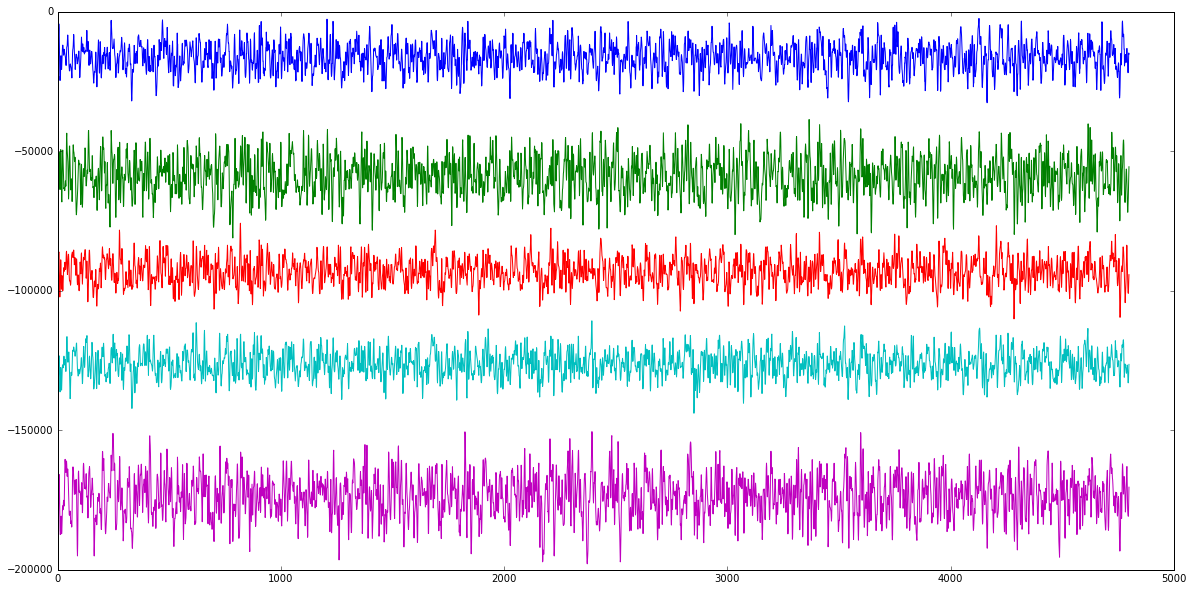

In [72]:
Fs = 48000
time_value = 100/1000

num_samples = int(Fs*time_value)

indices = np.arange(num_samples)

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111)
for i, chan_data in enumerate(channel_data):
    chan_data = chan_data[indices]
    if i == 0:
        min_value = np.amin(chan_data)
    else:
        min_value = min_value - (np.amax(chan_data) - np.amin(chan_data))
        
    ax.plot(chan_data + min_value)
    
#fig.show()

In [54]:
print(num_samples)

480


6.25e-05

In [135]:
post[-1]

array([ 9337.68])

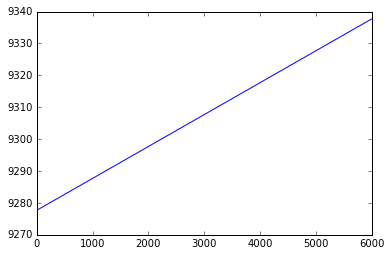

In [136]:
plt.plot(post)

In [193]:
#pos_fpath = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\20170823-3-CYLINDEROPENFIELD_Mult_converted.pos'
pos_fpath = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\20170823-2-CYLINDEROPENFIELD_converted.pos'
posx, posy, post = getpos(pos_fpath, 'BehaviorRoom', method='raw')
print(np.hstack((post,posx,posy)))

[[  4.16444000e+05   6.90000000e+01   1.50000000e+01]
 [  4.16445000e+05   7.00000000e+01   1.50000000e+01]
 [  4.16446000e+05   7.00000000e+01   1.90000000e+01]
 ..., 
 [  4.46444000e+05   2.80000000e+01   1.45000000e+02]
 [  4.46444000e+05   2.80000000e+01   1.45000000e+02]
 [  4.46444000e+05   2.80000000e+01   1.45000000e+02]]


In [188]:
def getpos2(pos_fpath, arena, method=''):
    '''getpos function:
    ---------------------------------------------
    variables:
    -pos_fpath: the full path (C:\example\session.pos)

    output:
    t: column numpy array of the time stamps
    x: a column array of the x-values (in pixels)
    y: a column array of the y-values (in pixels)
    '''
    with open(pos_fpath, 'rb+') as f:  # opening the .pos file
        headers = ''  # initializing the header string
        for line in f:  # reads line by line to read the header of the file
            # print(line)
            if 'data_start' in str(line):  # if it reads data_start that means the header has ended
                headers += 'data_start'
                break  # break out of for loop once header has finished
            elif 'duration' in str(line):
                headers += line.decode(encoding='UTF-8')
            elif 'num_pos_samples' in str(line):
                num_pos_samples = int(line.decode(encoding='UTF-8')[len('num_pos_samples '):])
                headers += line.decode(encoding='UTF-8')
            elif 'bytes_per_timestamp' in str(line):
                bytes_per_timestamp = int(line.decode(encoding='UTF-8')[len('bytes_per_timestamp '):])
                headers += line.decode(encoding='UTF-8')
            elif 'bytes_per_coord' in str(line):
                bytes_per_coord = int(line.decode(encoding='UTF-8')[len('bytes_per_coord '):])
                headers += line.decode(encoding='UTF-8')
            elif 'timebase' in str(line):
                timebase = (line.decode(encoding='UTF-8')[len('timebase '):]).split(' ')[0]
                headers += line.decode(encoding='UTF-8')
            elif 'pixels_per_metre' in str(line):
                ppm = float(line.decode(encoding='UTF-8')[len('pixels_per_metre '):])
                headers += line.decode(encoding='UTF-8')
            elif 'min_x' in str(line) and 'window' not in str(line):
                min_x = int(line.decode(encoding='UTF-8')[len('min_x '):])
                headers += line.decode(encoding='UTF-8')
            elif 'max_x' in str(line) and 'window' not in str(line):
                max_x = int(line.decode(encoding='UTF-8')[len('max_x '):])
                headers += line.decode(encoding='UTF-8')
            elif 'min_y' in str(line) and 'window' not in str(line):
                min_y = int(line.decode(encoding='UTF-8')[len('min_y '):])
                headers += line.decode(encoding='UTF-8')
            elif 'max_y' in str(line) and 'window' not in str(line):
                max_y = int(line.decode(encoding='UTF-8')[len('max_y '):])
                headers += line.decode(encoding='UTF-8')
            elif 'pos_format' in str(line):
                headers += line.decode(encoding='UTF-8')
                if 't,x1,y1,x2,y2,numpix1,numpix2' in str(line):
                    two_spot = True
                else:
                    two_spot = False
                    print('The position format is unrecognized!')

            else:
                headers += line.decode(encoding='UTF-8')

    if two_spot:

        bytes_offset = bytes_per_timestamp + 8 * bytes_per_coord  # number of bytes per position set

        '''Run when two spot mode is on, (one_spot has the same format so it will also run here)'''
        with open(pos_fpath, 'rb+') as f:
            '''get_pos for one_spot'''
            pos_data = f.read()  # all the position data values (including header)
            pos_data = pos_data[len(headers):]  # removes the header values

            x = np.zeros((num_pos_samples, 2))  # [x1, x2]
            y = np.zeros((num_pos_samples, 2))  # [y1, y2]
            t = np.zeros((num_pos_samples, 1))  # [t]

            numpix1 = np.zeros((num_pos_samples, 1))  # [numpix1]
            numpix2 = np.zeros((num_pos_samples, 1))  # [numpix2]

            t_start = 0  # the time is the first value
            x1_start = bytes_per_timestamp  # 4, x1 is the second value
            y1_start = bytes_per_timestamp + bytes_per_coord  # 6, y1 is the third value

            x2_start = bytes_per_timestamp + 2 * bytes_per_coord  # 8, x2 is the fourth value
            y2_start = bytes_per_timestamp + 3 * bytes_per_coord  # 10, y2 is the fifth value

            numpix1_start = bytes_per_timestamp + 4 * bytes_per_coord
            numpix2_start = bytes_per_timestamp + 5 * bytes_per_coord
            
            z = 0
            
            for sample in range(0, num_pos_samples):
                '''struct outputs a tuple so make sure you take the 0th index to make it just a number'''
                # used np.asarray to convert from tuple (the output from struct.unpack, to a np.array)
                byte_values = pos_data[t_start+4 + sample * bytes_offset:t_start + sample * bytes_offset+ 20]
                print(byte_values)
                
                z +=1
                
                if z > 4:
                    break
                
                t[sample] = np.asarray(struct.unpack('>i',
                                                     pos_data[t_start +
                                                              sample * bytes_offset:bytes_per_timestamp +
                                                                                    sample * bytes_offset])[0])
                # each sample is 20 bytes long, 1 4-byte frame count, and 8 2-byte words

                x[sample] = np.asarray(struct.unpack('>2h',
                                                     pos_data[x1_start +
                                                              sample * bytes_offset:(x1_start + bytes_per_coord) +
                                                                                    sample * bytes_offset] +
                                                     pos_data[x2_start + sample * bytes_offset:(x2_start +
                                                                                                bytes_per_coord) +
                                                                                               sample * bytes_offset]),
                                       dtype=tuple)

                y[sample] = np.asarray(
                    struct.unpack('>2h',
                                  pos_data[y1_start +
                                           sample * bytes_offset:(y1_start + bytes_per_coord) +
                                                                 sample * bytes_offset] +
                                  pos_data[y2_start + sample * bytes_offset:(y2_start + bytes_per_coord) +
                                                                            sample * bytes_offset]), dtype=tuple)

                numpix1[sample] = np.asarray(
                    struct.unpack('>h', pos_data[numpix1_start +
                                                 sample * bytes_offset:(numpix1_start +
                                                                        bytes_per_coord) + sample * bytes_offset])[0])

                numpix2[sample] = np.asarray(
                    struct.unpack('>h', pos_data[numpix2_start +
                                                 sample * bytes_offset:(numpix2_start +
                                                                        bytes_per_coord) + sample * bytes_offset])[0])

        if method == 'raw':
            return x[:, 0].reshape((len(x), 1)), y[:, 0].reshape((len(y), 1)), t[:, 0].reshape((len(t), 1))

        t = t * (1 / int(timebase))  # converting the frame number from Axona to the time value

        # values that are NaN are set to 1023 in Axona's system, replace these values by NaN's

        for sample in range(0, len(t)):
            for x_index in range(len(x[sample])):  # replace the 1023 values with nan's
                if x[sample][x_index] == 1023:
                    x[sample][x_index] = np.nan

            for y_index in range(len(y[sample])):  # replace the 1023 values with nan's
                if y[sample][y_index] == 1023:
                    y[sample][y_index] = np.nan

            if numpix1[sample] == 1023:  # replace the 1023 values with nan's
                numpix1[sample] = np.nan

            if numpix2[sample] == 1023:  # replace the 1023 values with nan's
                numpix2[sample] = np.nan

                # print('Time: ' + str(t[sample]) + ', X: ' + str(x[sample]) + ', Y: ' + str(y[sample]) + ', np1: ' + str(numpix1[sample]) + ', np2: ' + str(numpix2[sample]))

        # checks for the column of Nans and chooses the column (most likely the first column)
        if np.nansum(x[:, 0]) > np.nansum(x[:, 1]):
            '''the first column doesnt have the nans, set the values of x and y to the first column'''
            x = x[:, 0]
            y = y[:, 0]
        else:
            x = x[:, 1]
            y = y[:, 1]

        didFix, fixedPost = fixTimestamps(t)

        if didFix:
            t = fixedPost

        x, y = arena_config(x, y, arena, conversion=ppm, center=np.asarray([np.mean([min_x, max_x]),
                                                                            np.mean([min_y,max_y])]))

        # remove any NaNs at the end of the file
        x, y, t = removeNan(x, y, t)


    else:
        print("Haven't made any code for this part yet.")

    return x.reshape((len(x), 1)), y.reshape((len(y), 1)), t.reshape((len(t), 1))


In [189]:
print(pos_fpath)
posx, posy, post = getpos2(pos_fpath, 'BehaviorRoom', method='raw')

C:\Users\Geoffrey Barrett\Desktop\RAW Data\20170823-2-CYLINDEROPENFIELD_converted.pos
b'\x00E\x00\x0f\x03\xff\x03\xff\x03\xff\x03\xff\x03\xff\x03\xff'
b'\x00F\x00\x0f\x03\xff\x03\xff\x03\xff\x03\xff\x03\xff\x03\xff'
b'\x00F\x00\x13\x03\xff\x03\xff\x03\xff\x03\xff\x03\xff\x03\xff'
b'\x00E\x00\x11\x03\xff\x03\xff\x03\xff\x03\xff\x03\xff\x03\xff'
b'\x00D\x00\x13\x03\xff\x03\xff\x03\xff\x03\xff\x03\xff\x03\xff'


In [185]:
with open(bin_filename, 'rb') as f:
    #open the bin file
    data = []

    for z, line in enumerate(f):
        #print(line)
        if data != []:
            data += line
        else:
            data = line
        
        if z > 30:
            break
            
data

b'ADU1\xd1\xb1\xde\x06\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xaa\x1fB\x1b\x9a<\xa6\xe4\xf8\xfe\x82\xfeX\xfen\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc8\x1f>\x1b\x96<r\xe4\x0e\xff.\xfe\xdc\xfd\xfe\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x